# FlaNN
---
## Download Dataset

In [1]:
%pip install numpy h5py requests pyflann-ibeis

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import h5py
import os
import requests
import tempfile
import time

from pyflann_ibeis import *

In [3]:
with tempfile.TemporaryDirectory() as tmp:
    response = requests.get("http://ann-benchmarks.com/sift-128-euclidean.hdf5")
    loc = os.path.join(tmp, "sift.hdf5")
    with open(loc, 'wb') as f:
        f.write(response.content)
    
    sift_h5py = h5py.File(loc, "r")

In [4]:
list(sift_h5py.keys())

['distances', 'neighbors', 'test', 'train']

In [5]:
dataset = sift_h5py['train']
queries = sift_h5py['test']
print(dataset.shape)
print(queries.shape)

(1000000, 128)
(10000, 128)


## Build FlaNN Index
---

In [6]:
normalized_dataset = dataset / np.linalg.norm(dataset, axis=1)[:, np.newaxis]
# configure FlaNN as a tree
flann = FLANN()
# use FLANN().build_index() to instead create a TensorFlow-compatible indices
flann.build_index(normalized_dataset, algorithm='kdtree', trees=4, max_neighbors=10, cores=4, leaf_max_size=2000)

{'algorithm': 'kdtree',
 'checks': 32,
 'eps': 0.0,
 'sorted': 1,
 'max_neighbors': 10,
 'cores': 4,
 'trees': 4,
 'leaf_max_size': 2000,
 'branching': 32,
 'iterations': 5,
 'centers_init': 'random',
 'cb_index': 0.5,
 'target_precision': 0.8999999761581421,
 'build_weight': 0.009999999776482582,
 'memory_weight': 0.0,
 'sample_fraction': 0.10000000149011612,
 'table_number_': 12,
 'key_size_': 20,
 'multi_probe_level_': 2,
 'log_level': 'warning',
 'random_seed': 200857325,
 'speedup': 0.0}

In [7]:
def compute_recall(neighbors, true_neighbors):
    total = 0
    for gt_row, row in zip(true_neighbors, neighbors):
        total += np.intersect1d(gt_row, row).shape[0]
    return total / true_neighbors.size

## FlaNN interface features
---

In [9]:
import matplotlib.pyplot as plt

Trees: 1
Recall: 0.00019
Time: 0.0580291748046875
Trees: 2
Recall: 0.00014
Time: 0.03679919242858887
Trees: 3
Recall: 1e-05
Time: 0.03672289848327637
Trees: 4
Recall: 5e-05
Time: 0.03857231140136719
Trees: 5
Recall: 3e-05
Time: 0.04320955276489258
Trees: 6
Recall: 3e-05
Time: 0.04392409324645996
Trees: 7
Recall: 0.0
Time: 0.0443882942199707
Trees: 8
Recall: 9e-05
Time: 0.04745936393737793
Trees: 9
Recall: 4e-05
Time: 0.04694080352783203
Trees: 10
Recall: 2e-05
Time: 0.052318572998046875


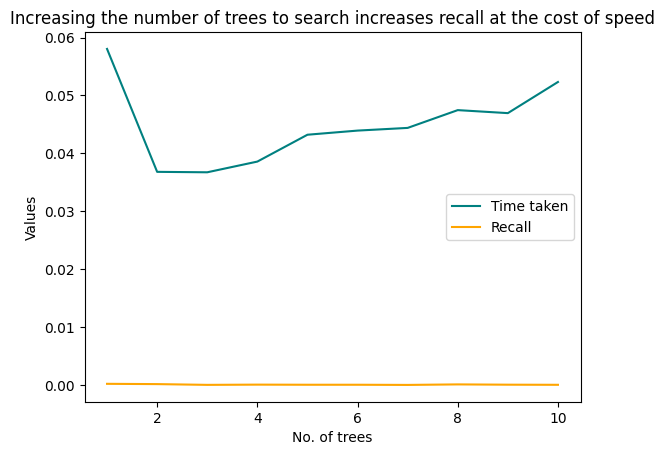

In [11]:
trees = range(1, 11)
times = []
recalls = []
for tree in trees:
    print("Trees:",tree)
    flann.build_index(normalized_dataset, algorithm='kdtree', trees=tree, max_neighbors=10)
    start = time.time()
    neighbors, distances = flann.nn_index(queries)
    end = time.time()

    # select top 10 from ground truth
    print("Recall:", compute_recall(neighbors, sift_h5py['neighbors'][:, :10]))
    recalls.append(compute_recall(neighbors, sift_h5py['neighbors'][:, :10]))
    print("Time:", end - start)
    times.append(end - start)

plt.plot(trees, times, color='teal', label='Time taken')
plt.plot(trees, recalls, color='orange', label='Recall')
plt.legend()
plt.xlabel('No. of trees')
plt.ylabel('Values')
plt.title('Increasing the number of trees to search increases recall at the cost of speed')
plt.show()

Leaf size: 0
Recall: 2e-05
Time: 0.08971929550170898
Leaf size: 100
Recall: 0.00011
Time: 0.041979074478149414
Leaf size: 200
Recall: 3e-05
Time: 0.04376721382141113
Leaf size: 300
Recall: 3e-05
Time: 0.04273843765258789
Leaf size: 400
Recall: 0.00012
Time: 0.042041778564453125
Leaf size: 500
Recall: 5e-05
Time: 0.04623222351074219
Leaf size: 600
Recall: 3e-05
Time: 0.043622732162475586
Leaf size: 700
Recall: 2e-05
Time: 0.06288385391235352
Leaf size: 800
Recall: 3e-05
Time: 0.0551455020904541
Leaf size: 900
Recall: 0.00011
Time: 0.046335458755493164
Leaf size: 1000
Recall: 2e-05
Time: 0.04665112495422363


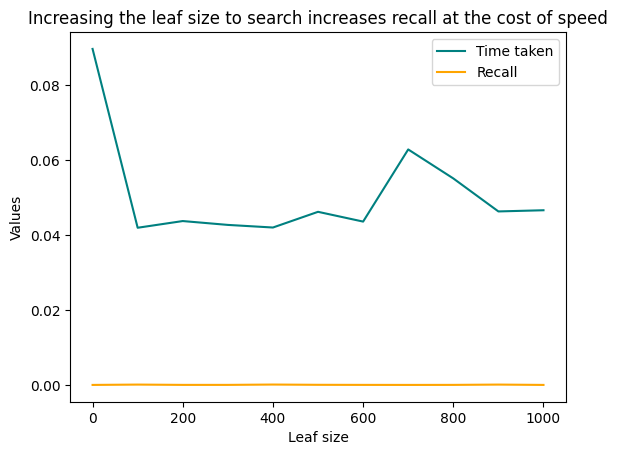

In [14]:
leaf_size = range(0, 1001, 100)
times = []
recalls = []
for leaf in leaf_size:
    print("Leaf size:",leaf)
    flann.build_index(normalized_dataset, algorithm='kdtree', trees=4, max_neighbors=10, leaf_max_size=leaf)
    start = time.time()
    neighbors, distances = flann.nn_index(queries)
    end = time.time()

    # select top 10 from ground truth
    print("Recall:", compute_recall(neighbors, sift_h5py['neighbors'][:, :10]))
    recalls.append(compute_recall(neighbors, sift_h5py['neighbors'][:, :10]))
    print("Time:", end - start)
    times.append(end - start)

plt.plot(leaf_size, times, color='teal', label='Time taken')
plt.plot(leaf_size, recalls, color='orange', label='Recall')
plt.legend()
plt.xlabel('Leaf size')
plt.ylabel('Values')
plt.title('Increasing the leaf size to search increases recall at the cost of speed')
plt.show()

Branch: 0
Recall: 7e-05
Time: 0.07348465919494629
Branch: 2
Recall: 3e-05
Time: 0.04726290702819824
Branch: 4
Recall: 2e-05
Time: 0.03968238830566406
Branch: 6
Recall: 3e-05
Time: 0.0392909049987793
Branch: 8
Recall: 8e-05
Time: 0.03976798057556152
Branch: 10
Recall: 2e-05
Time: 0.040026187896728516
Branch: 12
Recall: 1e-05
Time: 0.03940153121948242
Branch: 14
Recall: 6e-05
Time: 0.037307024002075195
Branch: 16
Recall: 0.0
Time: 0.03857088088989258
Branch: 18
Recall: 4e-05
Time: 0.03868222236633301
Branch: 20
Recall: 1e-05
Time: 0.0399327278137207
Branch: 22
Recall: 3e-05
Time: 0.04146862030029297
Branch: 24
Recall: 1e-05
Time: 0.040628671646118164
Branch: 26
Recall: 4e-05
Time: 0.03995776176452637
Branch: 28
Recall: 7e-05
Time: 0.03965425491333008
Branch: 30
Recall: 7e-05
Time: 0.0354464054107666
Branch: 32
Recall: 4e-05
Time: 0.03957796096801758
Branch: 34
Recall: 7e-05
Time: 0.038347482681274414
Branch: 36
Recall: 2e-05
Time: 0.03908681869506836
Branch: 38
Recall: 5e-05
Time: 0.0389

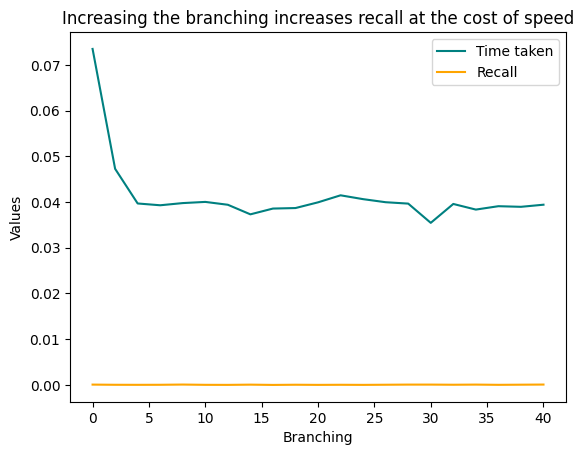

In [18]:
branching = range(0, 41, 2)
times = []
recalls = []
for branch in branching:
    print("Branch:",branch)
    flann.build_index(normalized_dataset, algorithm='kdtree', trees=4, max_neighbors=10, branching=branch)
    start = time.time()
    neighbors, distances = flann.nn_index(queries)
    end = time.time()

    # select top 10 from ground truth
    print("Recall:", compute_recall(neighbors, sift_h5py['neighbors'][:, :10]))
    recalls.append(compute_recall(neighbors, sift_h5py['neighbors'][:, :10]))
    print("Time:", end - start)
    times.append(end - start)

plt.plot(branching, times, color='teal', label='Time taken')
plt.plot(branching, recalls, color='orange', label='Recall')
plt.legend()
plt.xlabel('Branching')
plt.ylabel('Values')
plt.title('Increasing the branching increases recall at the cost of speed')
plt.show()